# Simulating amplitude damping of a qubit using IBMQ
#### Goal: To find the evolution of the population density of state $|1\rangle$ for a qubit under amplitude damping.

In [1]:
import numpy as np

#Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers import *
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

#Loading IBM Quantum account(s)
provider = IBMQ.load_account()

## Markovian amplitude damping of a qubit

Simulation of an open quantum system involves following steps:
- Writing the Kraus representation of the dynamics
- Using Stinespring dilation theorem to find a unitary operator for the evolution of system and environment
- Decomposing the unitary operator into elementary gates to create the quantum circuit for the dynamics

This is a Markovian process model. Kraus operator representation for Markovian amplitude damping of a qubit is given by,

$$\Omega_0 = |0\rangle\langle0| + \sqrt{1-\gamma^2} |1\rangle\langle1| $$  
$$\Omega_1 = \gamma |0\rangle\langle1| $$

The unitary operator for Markovian evolution,

$$U_{SE}(\Delta t) = \Omega_0 \otimes |0\rangle\langle0|_E + \Omega_1 \otimes |1\rangle\langle0|_E$$

which can be written as:

$$U_{SE} = \hat{S}\hat{C}$$

where,
$$\hat{C} = |0\rangle\langle0|_S \otimes |0\rangle\langle0|_E + |1\rangle\langle1|_S \otimes R_y(\theta) |0\rangle\langle0|_E$$

$$\hat{S} = I_S \otimes |0\rangle\langle0|_E + NOT_S \otimes |1\rangle\langle1|_E$$

where $sin(\frac{\theta}{2}) = \gamma, R_y(\theta)|0\rangle = \sqrt{1-\gamma^2}|0\rangle + \gamma|1\rangle$.

The unitary operator $U_{SE}$ can be implemented using $\hat{C}$ and $\hat{S}$ operators. $\hat{C}$ is implemented using the controlled rotation gate and $\hat{S}$ operator is implemented using the CNOT gate. The environment is traced out at the end of a step.

#### Creating a quantum circuit having one system qubit and one environment qubit along with one classical bit:

In [2]:
q = QuantumRegister(1,'q')
e = QuantumRegister(1,'e')
c = ClassicalRegister(1,'c')

#### Defining a function which creates the quantum circuit for Marokivan amplitude damping, for a given number of steps:

In [3]:
def damp_M(steps):
    
    qc = QuantumCircuit(q,e,c)
    theta = np.pi/8

    qc.x(q)
    qc.barrier()

    for i in range(steps):
        if (i>0):
            qc.reset(e)
        qc.cry(theta,q,e)
        qc.cx(e,q)
        qc.measure(e,c)
        qc.barrier()
    
    qc.measure(q,c)
    
    sim = Aer.get_backend('qasm_simulator')
    job = execute(qc, sim, shots=1024)
    res = job.result()
    counts = res.get_counts()

    return counts


#### Circuit for single step:

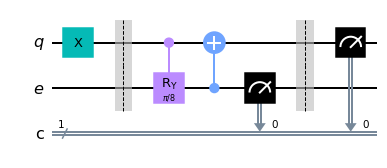

In [22]:
qc = damp_M(1)
qc.draw('mpl')

In [4]:
steps = np.linspace(0,150,51)
prob0 = []

for st in steps:
    co = damp_M(int(st))
    if '1' in co:
        prob0.append(co['1']/1024)
    else:
        prob0.append(0)

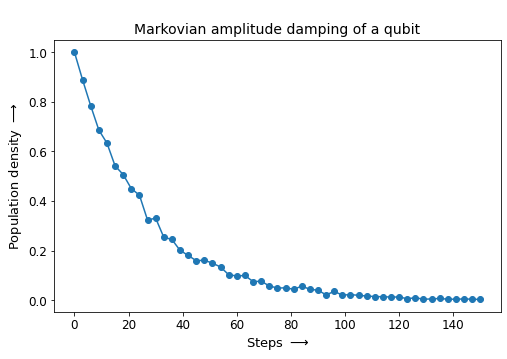

In [7]:
fig = plt.figure(figsize=(8,5))

plt.scatter(steps,prob0)
plt.plot(steps,prob0)

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('\nMarkovian amplitude damping of a qubit', size=14)
plt.xlabel(r'Steps $\longrightarrow$', size=13)
plt.ylabel(r'Population density $\longrightarrow$', size=13)

plt.show()

## Non-Markovian amplitude damping of a qubit
Simulating Non-Markovian systems is based on the idea of retaining some knowledge about the system in the ancillas. This can be accomplished by adding additional information-storing environment qubits. The environment is partially traced out at the end of each step, and SWAP gates are used to update the information stored on qubits for the following step. This makes it possible to simulate memory effects in dynamics.

In principle, we would need an infinite system to store information about the state at all times in the
past. We can get around this by using a discrete-time configuration (which is also suitable for digital quantum simulation) and ignoring contributions over a particular order. That is, evolution at $n^{th}$ step depends on last $k$ steps for some finite $k > 1$. Here we've taken $k = 3$.

#### Creating a quantum circuit having one system qubit and three environment qubit along with one classical bit:

In [8]:
q = QuantumRegister(1,'q')
e = QuantumRegister(3,'e')
c = ClassicalRegister(1,'c')

#### Defining a function which creates the quantum circuit for Non-Marokivan amplitude damping, for a given number of steps:

In [9]:
def damp_NM(steps):
    
    qc = QuantumCircuit(q,e,c)
    t1 = np.pi/8
    t2 = 5*np.pi/6
    t3 = np.pi

    qc.x(q)
    qc.barrier()

    for i in range(steps):
        qc.cry(t1,q,e[0])
        qc.cry(t2,q,e[1])
        qc.cry(t3,q,e[2])
        qc.cx(e[0],q[0])
        qc.measure(e[0],c)
        
        qc.reset(e[0])
        qc.swap(e[0],e[1])
        qc.swap(e[1],e[2])
        qc.barrier()
    
    qc.measure(q,c)
    
    sim = Aer.get_backend('qasm_simulator')
    job = execute(qc, sim, shots=1024)
    res = job.result()
    counts = res.get_counts()
    
    return counts


#### Circuit for single step:

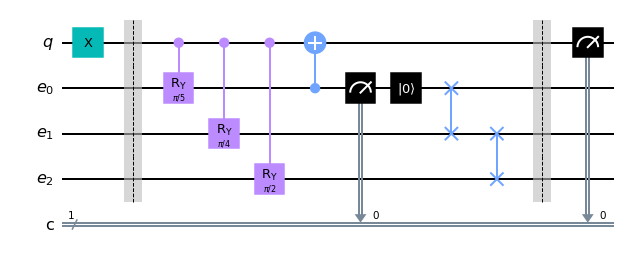

In [27]:
qc = damp_NM(1)
qc.draw('mpl')

In [10]:
steps = np.linspace(0,150,51)
prob0_NM = []

for st in steps:
    co = damp_NM(int(st))
    if '1' in co:
        prob0_NM.append(co['1']/1024)
    else:
        prob0_NM.append(0)

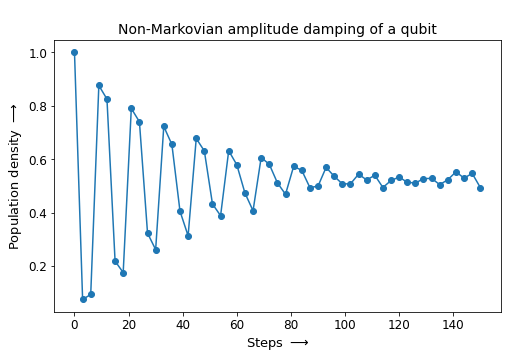

In [11]:
fig = plt.figure(figsize=(8,5))

plt.scatter(steps,prob0_NM)
plt.plot(steps,prob0_NM)

plt.xticks(size=12)
plt.yticks(size=12)

plt.title('\nNon-Markovian amplitude damping of a qubit', size=14)
plt.xlabel(r'Steps $\longrightarrow$', size=13)
plt.ylabel(r'Population density $\longrightarrow$', size=13)

plt.show()

## Comparing Markovian and Non-Markovian damping of a qubit

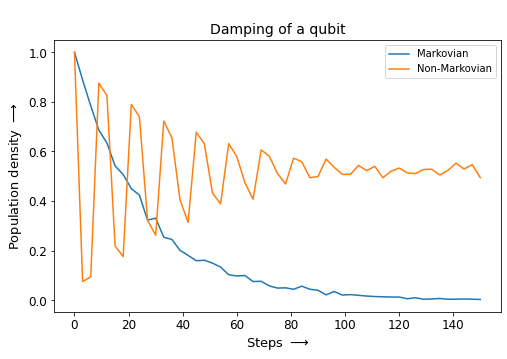

In [20]:
fig = plt.figure(figsize=(8,5))

plt.plot(steps,prob0)
#plt.scatter(steps,prob0)

plt.plot(steps,prob0_NM)
#plt.scatter(steps,prob0_NM)

plt.xticks(size=12)
plt.yticks(size=12)

plt.legend(['Markovian','Non-Markovian'])
plt.title('\nDamping of a qubit', size=14)
plt.xlabel(r'Steps $\longrightarrow$', size=13)
plt.ylabel(r'Population density $\longrightarrow$', size=13)

plt.show()


>**Note:** The mathematical formalism and circuit decomposition shown are taken from the paper mentioned below. This is just an implementation of the theoretical work presented there.
>
> Ref.: *Gupta, Pragati, and C. M. Chandrashekar. "Optimal quantum simulation of open quantum systems." arXiv preprint arXiv:2012.07540 (2020),* <a href="https://arxiv.org/abs/2012.07540">(ArXiv link)</a>.